# 2021-06-09 Large Ensembles


## Scientific Goals:
- Understand what at large ensemble is and what model output looks like
- Know where to look for help when navigating the huge array of output data
- How to calculate common ensemble metrics

## Coding Goals:
- Loading data with dask
- Combining data from mltiple files
- Calculating ensemble means and other statistics

## Notebook Outline:

**1. CanESM2 data:**
* 1.1 Download a zipped file of 50 NetCDF files and `unzip` into new directory
* 1.2 Load all 50 files into memory using `dask` chunks
* 1.3 Select the northern hemisphere ice (>30N) using `xaray.where`
* 1.4 Plot with polar stereographic plots using `cartopy`
* 1.5 Mask the land using a new file
* 1.6 Plot the masked data using `cartopy`
* 1.7 Sum up the sea ice area for each member using `xarray.sum()`
* 1.8 Save a `NetCDF` file of the data for September for the years 2000-2020

**2. CESM1 data**
* 2.1 Load and plot reduced CESM dataset using `xarray` and `cartopy`
* 2.2 Regrid CESM data into a new net `NetCDF` file
* 2.3 Plot our regridded data using `cartopy`

# Large Ensemble overview
**Climate models are essentually a whole load of code computing changes of variables for each grid cell for every time step. <br>
Climate models follow prescribed forcings (see [CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6)), differences between models are due to differing understandings between the mathematical interpretation of these forcings.<br>  
Large ensembles do the same thing, but they induce a small amount of uncertainty to diverge the model output<br>
For example in CESM1 LE temperature is perturbed by 10$^{-14}$K which causes global temperature divergence in January 1920 (see below)**<br>

<img src="http://www.cesm.ucar.edu/projects/community-projects/LENS/images/Figure2.gif" alt="CESM LE divergence" width="700"/>

**The atmosphere, land, and sea ice have short 'memories' so can quickly diverge. The ocean has a longer memory so it initialized from observations and only the uppper ocean can diverge over the run of the model.<br>
In a practical sense, this means that different ensemble members will diverge to have different 'weather' within a few days to months.<br>
Different modes of climate variability e.g. ENSO will appear slightly later, but very low frequency variability (that associated with the deep ocean) will not be captured.<br>
This means each different ensemble member is equally likely to occur and the only difference between them is random or 'internal variability' as it is not caused by the model or forcings.**<br>

**One of the most important differences between models is their use of grids, which can be a headache, today we'll go over some examples to help you deal with some common issues.<br>
Don't worry if some of this goes over your heads, this is mostly for reference.<br>
The figure below shows an exampled of a 'tripolar' grid, CESM uses a 'displaced pole' in Greenland, and CanESM2 which we'll use as our first example today uses a regular lat/lon grid** <br>
<img src="https://www.researchgate.net/profile/V-Balaji-4/publication/228641121/figure/fig2/AS:301996147003394@1449012900530/The-tripolar-grid-often-used-in-ocean-modeling-Polar-singularities-are-placed-over-land.png" alt="Tripolar grid" width="400"/>
<img src="https://www.cesm.ucar.edu/models/cesm1.0/cesm/cesm_doc_1_0_4/greenland_pole_grid.jpg" alt="Displaced Greenland Pole (CESM)" width="400"/>


# Activities

In [2]:
import datetime
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import dask

In [ ]:
#sometimes cartopy has difficulties with shapely, don't run this unless your kernel dies when trying to use caropy.ccrs (you will need to rerun all you cells again from after unzipping the data - start a 1.2)
# !pip install --no-binary shapely shapely --force

# 1. Download the CanESM2 data
## 1.1 Download a zipped file and unzip into a single directory of 50 NetCDF files
**<span style="color:blue">Maually download `CanESM2_SIC_1950_2100.zip` from [Google Drive](https://drive.google.com/drive/folders/1k_cdO6wtwK6TkufIOeZPiLFORW897N17?usp=sharing) <br>
Then in your terminal use the following command in that directory** <br>
`unzip CanESM2_SIC_1950_2100.zip -d CanESM2_SIC_members` <br>
**This unzips files of the 50 members into a new directory 'CanESM2_SIC_members'** <br><br>

**Firstly, look at the size of each of the files with `ls -lh`. <br>
    You should see they are ~6 MB. It would be okay to load all of these into memory, but for this exercise we'll follow a proceedure to assume this would not be possible.** 

In [3]:
!ls -lh CanESM2_SIC_members

total 628984
-rw-r--r--@ 1 atoc_reu_student  staff   6.2M Jan 17  2019 sic_OImon_CanESM2_historical_rcp85_r10i1p1_195001-210012.nc
-rw-r--r--@ 1 atoc_reu_student  staff   6.2M Jan 17  2019 sic_OImon_CanESM2_historical_rcp85_r11i1p1_195001-210012.nc
-rw-r--r--@ 1 atoc_reu_student  staff   6.2M Jan 17  2019 sic_OImon_CanESM2_historical_rcp85_r12i1p1_195001-210012.nc
-rw-r--r--@ 1 atoc_reu_student  staff   6.1M Jan 17  2019 sic_OImon_CanESM2_historical_rcp85_r13i1p1_195001-210012.nc
-rw-r--r--@ 1 atoc_reu_student  staff   6.1M Jan 17  2019 sic_OImon_CanESM2_historical_rcp85_r14i1p1_195001-210012.nc
-rw-r--r--@ 1 atoc_reu_student  staff   6.1M Jan 17  2019 sic_OImon_CanESM2_historical_rcp85_r15i1p1_195001-210012.nc
-rw-r--r--@ 1 atoc_reu_student  staff   6.2M Jan 17  2019 sic_OImon_CanESM2_historical_rcp85_r16i1p1_195001-210012.nc
-rw-r--r--@ 1 atoc_reu_student  staff   6.2M Jan 17  2019 sic_OImon_CanESM2_historical_rcp85_r17i1p1_195001-210012.nc
-rw-r--r--@ 1 atoc_reu_student  staff   6.1

**Let's quickly load the first member (look at the naming convention and note** `_r1i1p1_` **tells us this)**

In [4]:
CanESM2_member_1 = xr.open_dataset('CanESM2_SIC_members/sic_OImon_CanESM2_historical_rcp85_r1i1p1_195001-210012.nc')

In [5]:
CanESM2_member_1

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 64, lon: 128, time: 1812)
Coordinates:
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time       (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    sic        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes: (12/33)
    institution:               CCCma (Canadian Centre for Climate Modelling a...
    institute_id:              CCCma
    experiment_id:             historical-r1
    source:                    CanESM2
    model_id:                  CanESM2
    forcing:                   GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes CO2,CH4...
    ...                        ...
    parent_experiment:         N/A
    modeling_realm:            seaIce ocean
    realization:               1
    cmor_version:              2.8.2
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1

## 1.2 Load all of the 50 members into xarray
**To load a whole load of large files into memory we can either:**
- Sequentially load the files and extract a portion of each file to a variable or output to a reduced dataset file
- Use dask to avoid reading in the data explicitly into memory, rather it just looks at how the data is structured and grabs the part of the dataset that's needed for a specific computation <br> This is like having all of Google Maps availible to you, but you don't download it all before you start navigating, instead you just get the route you will use to get to your destination.

**Loading all of these into an** `xarray.DataSet` **requires obtaining a list of the files we want**

In [ ]:
CanESM2_file_list = os.listdir('CanESM2_SIC_members')

**The method above produces an unordered list, furthermore if we were to sort this list `r19i` comes before `r1i`**<br>
Note here `r19i` means the 19th ensemble member and CanESM5 has 50 members

In [ ]:
CanESM2_file_list[:10]

**Instead one way of doing this is by constructing the file names ourselves as below.** <br>
**Note we call `chunks=25` here, this does not load the data into memory. The chunk size is not overly important, it is usually a similar or smaller size to one of your dimensions**

In [ ]:
%%time 
#this will output how long this cell took to run

CanESM2_files = [] #initialize list
member_numbers = np.arange(1,51,1) #we have member numbers 1-50

for mem_i in member_numbers: #loop through the 50 members
    temp_file = xr.open_dataset('CanESM2_SIC_members/sic_OImon_CanESM2_historical_rcp85_r{}i1p1_195001-210012.nc'.format(mem_i), chunks=25)
    CanESM2_files.append(temp_file)

In [ ]:
CanESM2_files[:2]

**We now have a long list of** `xarray DataSets`**, to combine into a single dataset we can use** `xr.concat`

In [ ]:
CanESM2_SIC_1950_2100 = xr.concat((CanESM2_files), dim='member') #this concatenates along a new dimension called 'member'

<span style="color:blue"> **Look at the dask vizualization by clicking on the disk icon in the far left, after executing the next cell**

In [ ]:
CanESM2_SIC_1950_2100['sic'].sel(time='2020')

**Note the dimension** `member` **doesn't have coordinates, so we can add those in like this. Note also all the origional attributes have been retained**

In [ ]:
CanESM2_SIC_1950_2100['member'] = np.arange(1,51,1)

In [ ]:
CanESM2_SIC_1950_2100

**Alternatively we can use** `xarray.open_mf_dataest` **which is a much simpler process if we want to load all of the files, we still use dask with the keyword** `chunks=25`. <br>
**Note we use** `concat_dim = 'member'` **(a new dimension) and** `combine='nested'` **to reuse the same coordinates for all files.**

In [5]:
%time

CanESM2_SIC_1950_2100_alt = xr.open_mfdataset('CanESM2_SIC_members/*.nc', concat_dim='member', combine='nested', chunks=25)
#here we use concat_dim = 'member' (a new dimension) and combine='nested' to reuse the same coordinates for all files


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [7]:
CanESM2_SIC_1950_2100_alt['member']

<xarray.DataArray 'member' (member: 50)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
Dimensions without coordinates: member

In [8]:
CanESM2_SIC_1950_2100_alt['member'] = np.arange(1, 51, 1)
CanESM2_SIC_1950_2100_alt

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 64, lon: 128, member: 50, time: 1812)
Coordinates:
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time       (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member     (member) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (member, lat, bnds) float64 dask.array<chunksize=(1, 25, 2), meta=np.ndarray>
    lon_bnds   (member, lon, bnds) float64 dask.array<chunksize=(1, 25, 2), meta=np.ndarray>
    sic        (member, time, lat, lon) float32 dask.array<chunksize=(1, 25, 25, 25), meta=np.ndarray>
    time_bnds  (member, time, bnds) object dask.array<chunksize=(1, 25, 2), meta=np.ndarray>
Attributes: (12/33)
    institution:               CCCma (Canadian Centre for Climate Modelling a...
    institute_id:              CCCma
    experiment_id:             historical-r1
    source:                    CanESM2
    model_id:                  CanESM2
    forcing:                   GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes CO2,CH4...
    ...                        ...
    parent_experiment:         N/A
    modeling_realm:            seaIce ocean
    realization:               10
    cmor_version:              2.8.2
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1

In [9]:
CanESM2_SIC_1950_2100_alt.sel(member=7)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 64, lon: 128, time: 1812)
Coordinates:
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time       (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00
    member     int64 7
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(25, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(25, 2), meta=np.ndarray>
    sic        (time, lat, lon) float32 dask.array<chunksize=(25, 25, 25), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(25, 2), meta=np.ndarray>
Attributes: (12/33)
    institution:               CCCma (Canadian Centre for Climate Modelling a...
    institute_id:              CCCma
    experiment_id:             historical-r1
    source:                    CanESM2
    model_id:                  CanESM2
    forcing:                   GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes CO2,CH4...
    ...                        ...
    parent_experiment:         N/A
    modeling_realm:            seaIce ocean
    realization:               10
    cmor_version:              2.8.2
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1

## 1.3 Select the northern hemisphere ice (>30N)
**Instead of using the whole dataset we just want to look at September in the northern hemisphere, and only the** `sic` **variable**


In [12]:
month_ = 9
CanESM2_month = CanESM2_SIC_1950_2100_alt['sic'].sel(time=CanESM2_SIC_1950_2100_alt['time.month']==month_)
CanESM2_month


,Array,Chunk
Bytes,235.94 MiB,7.32 kiB
Shape,"(50, 151, 64, 128)","(1, 3, 25, 25)"
Count,262850 Tasks,65700 Chunks
Type,float32,numpy.ndarray


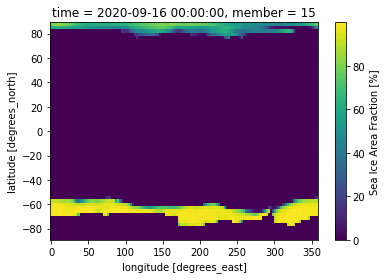

In [14]:
CanESM2_month.sel(member=15).sel(time='2020').plot()

**Now let's just select the Arctic, >30N should be fine**<br>
<span style="color:blue"> **Take a quick look at the** [`xarray.where`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html) **documentation before executing the cells below**

In [20]:
CanESM2_arctic = CanESM2_month.where(CanESM2_month['lat']>30, drop=True) #we use drop == True to drop the coordinate rather than return nan values


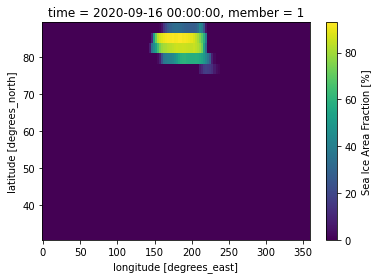

In [22]:
CanESM2_arctic.sel(time='2020').sel(member=1).plot()

**Plot 1950 year from this time series, just using** `xarray` <br>

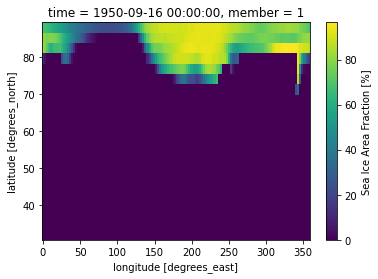

In [23]:
CanESM2_arctic.sel(member=1).sel(time='1950').plot();

<span style="color:blue">**Also plot a few other members to see how they differ**<br>

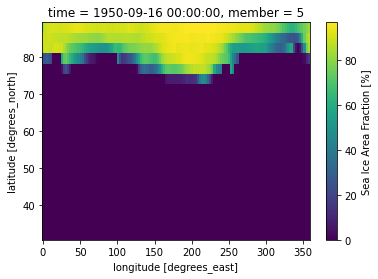

In [24]:
CanESM2_arctic.sel(member=5).sel(time='1950').plot();

<span style="color:red">**You can also make adifference plot between a member and the ensemble mean**

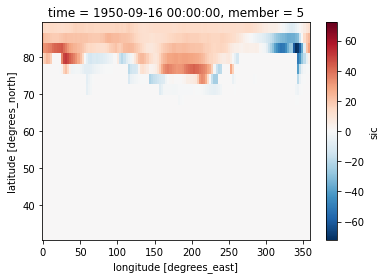

In [25]:
(CanESM2_arctic.sel(member=5).sel(time='1950') - CanESM2_arctic.mean('member').sel(time='1950')).plot();


## 1.4 Plot with a polar stereographic projection
<span style="color:blue">**Take a few minutes to have a look through this plotting function**

In [6]:
def circular_polar_plot(data, lat_min, colors, title_, no_col_bar=False, 
                        cbar_label=False, levels_=False, cbar_levels_=False, 
                        extend_kw=False, horizontal=False):
    
    '''
    This function requires an input of an xarray dataarray with lat/lon and a third varaible
    '''
    
    #define the overall figure charachteristics
    fig = plt.figure(figsize=[8,8]) #set the size of the figure
    ax = fig.add_subplot(projection = ccrs.NorthPolarStereo(central_longitude=0)) #define the axes in terms of the polar projection
    ax.set_extent((-180,180,int(lat_min),90), ccrs.PlateCarree()) #only include data above the minimum latitude
    
    #make the plot circular using matplotlib.path
    theta = np.linspace(0, 2*np.pi, 100) 
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T #matrix transpose
    circle = mpath.Path(verts * radius + center) #this is now a circle boundary defined in matplotlib
    ax.set_boundary(circle, transform=ax.transAxes) #cut the plot at the circle boundary
    
    if no_col_bar: #we don't include a colorbar if this argument is True
        data.plot(ax=ax,cmap=str(colors), add_colorbar=False, add_labels=False, transform=ccrs.PlateCarree())
    else:
        fig.subplots_adjust(right=0.87) #make space at the right side of the plot for the colorbar
        plotting = data.plot(ax=ax, cmap=str(colors), add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels_, add_labels=False)

        ####################################### define the colorbar ############################################
        if horizontal: #=True means we want the colobar horizontal
            orient = 'horizontal'
            cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.04]) #this is x,y position of the colorbar and length and height
        else:
            orient = 'vertical'
            cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
        
        #define whether the colorbar should be capped, default if no 'extend_kw' keyword is for both caps to be there so 'extend=both'
        if extend_kw:
             cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend=extend_kw, orientation=orient)
        else:
             cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend='both', orientation=orient)
        
        #set the label and label size of the colorbar
        if horizontal:
            cb.ax.set_xlabel(str(cbar_label), fontsize=20)
        else:
            cb.ax.set_ylabel(str(cbar_label), fontsize=20)
    
        cb.ax.tick_params(labelsize=20) #set the tick size on the colobar
        #####################################################################################################
    
    #add details to the figure after the data is plotted
    ax.coastlines() #add coastlines
    ax.gridlines() #add gridlines
    ax.set_title(str(title_), fontsize=20) #set the title and fontzise
    ax.set_facecolor('0.5') #make the background (usually land) gray

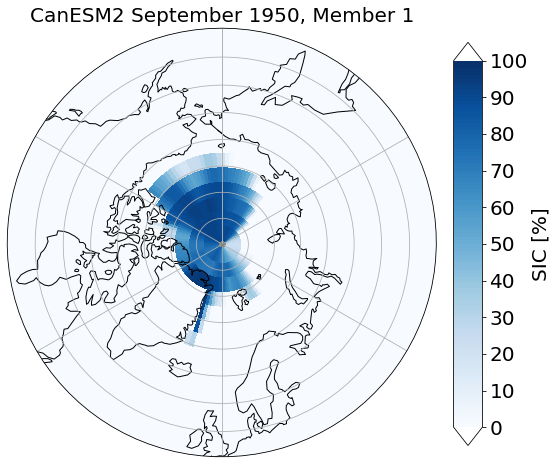

In [27]:
circular_polar_plot(CanESM2_arctic.sel(member=1).sel(time='1950'), 50, 'Blues', 'CanESM2 September 1950, Member 1',
                    cbar_label='SIC [%]', levels_=np.arange(0,101,1), cbar_levels_=np.arange(0,101,10))

## 1.5 Mask the land
**This doesn't look great, all the land and non-sea ice ocean has a value of 0 so it all looks the same** <br>
**We can make a land mask from the file** `sftlf_fx_CanESM2_historical_r0i0p0.nc` **which can also be downloaded from [Google Drive](https://drive.google.com/drive/folders/1k_cdO6wtwK6TkufIOeZPiLFORW897N17?usp=sharing)** <br>
**This data is freely availible (as is the rest of CMIP5) from https://esgf-node.llnl.gov/search/cmip5/**

In [28]:
area_land = xr.open_dataset('sftlf_fx_CanESM2_historical_r0i0p0.nc')


In [29]:
area_land

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 64, lon: 128)
Coordinates:
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 ...
    lon_bnds  (lon, bnds) float64 ...
    sftlf     (lat, lon) float32 ...
Attributes: (12/31)
    institution:            CCCma (Canadian Centre for Climate Modelling and ...
    institute_id:           CCCma
    experiment_id:          historical
    source:                 CanESM2 2010 atmosphere: CanAM4 (AGCM15i, T63L35)...
    model_id:               CanESM2
    forcing:                GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes CO2,CH4,N2...
    ...                     ...
    table_id:               Table fx (28 March 2011) c046d0887aeb2bb7ed34d638...
    title:                  CanESM2 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            0
    cmor_version:           2.5.4

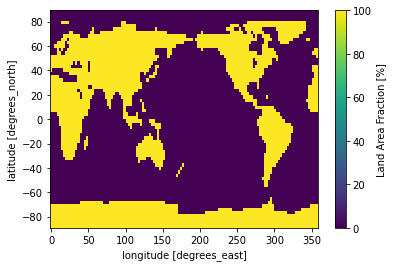

In [30]:
area_land['sftlf'].plot();

**The ocean is 0 and the land is 100, we only want the grid cells which = 0**

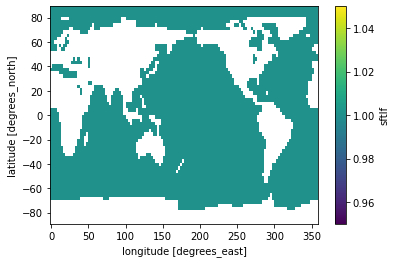

In [31]:
area_ocean = area_land['sftlf'].where(area_land['sftlf']==0) + 1 #cells which !=0 are defined as np.nan 
area_ocean.plot();


**Now we'll just select the data above 30N**

In [1]:
area_ocean_NH = area_ocean.where(area_ocean['lat']>30,drop=True) #drop = True means we don't have data for coordinates below 30N, if =False these would be np.nan
area_ocean_NH.plot();

NameError: name 'area_ocean' is not defined

**Now let's use this mask to mask our SIC data** <br>
**Note we are using dask chunks so this next cell executes almost instantly, but the calculations have not occured yet**<br>
N.B. sometimes if we're doing an operation such as addition or multiplication with 2 datasets which don't have exactly the same coordinate names but are the right size, `xarray` will get confused so we can ues `.values` after the dataarray with the coordinates we don't like.

In [37]:
CanESM2_SIC_masked = CanESM2_arctic * area_ocean_NH.values


In [38]:
CanESM2_SIC_masked

,Array,Chunk
Bytes,77.42 MiB,4.10 kiB
Shape,"(50, 151, 21, 128)","(1, 3, 14, 25)"
Count,394280 Tasks,43800 Chunks
Type,float32,numpy.ndarray


## 1.6 Plot the masked data

**Let's plot this for 1950, both member 1 and the ensemble mean**

CPU times: user 597 ms, sys: 106 ms, total: 703 ms
Wall time: 786 ms


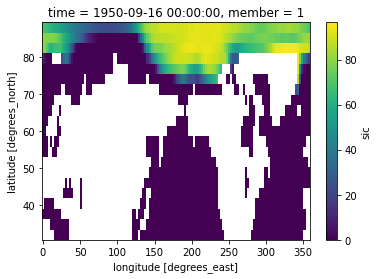

In [39]:
%%time
CanESM2_SIC_masked.sel(member=1).sel(time='1950').plot();

**The cell below should take a bit less than 50 times longer to run than the cell above**

In [ ]:
%%time
CanESM2_SIC_masked.mean('member').sel(time='1950').plot();

**It took quite a while to calculate the ensemble mean, note xarray is clever and whatever order you ask the calculations to be done (in a single line) it shouldn't matter for run time**

In [ ]:
%%time
CanESM2_SIC_masked.sel(time='1950').mean('member').plot();

**Now let's plot this with the land masked (it's now nan values so the gray background will show through)**

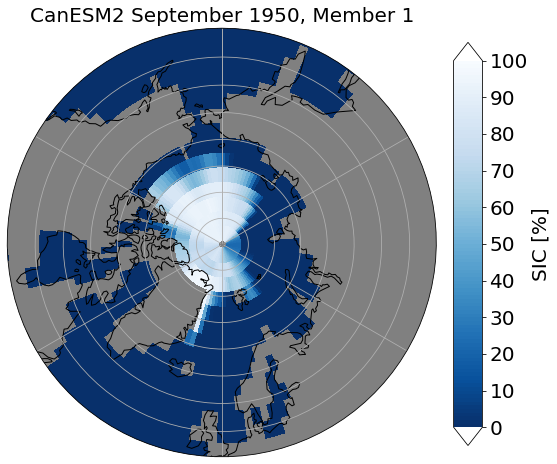

In [42]:
circular_polar_plot(CanESM2_SIC_masked.sel(time='1950').sel(member=1), 50, 'Blues_r', 'CanESM2 September 1950, Member 1',
                    cbar_label='SIC [%]', levels_=np.arange(0,101,1), cbar_levels_=np.arange(0,101,10))

**Let's also try two other key words:** `extend_kw='neither', horizontal=True` **to cut off the white caps of the colorbar and make the colorbar horizontal**

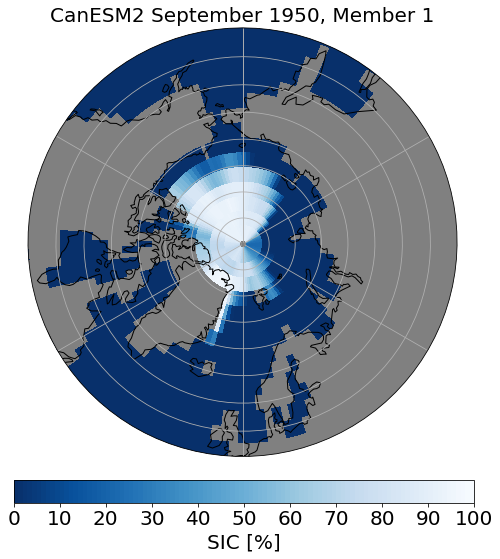

In [43]:
circular_polar_plot(CanESM2_SIC_masked.sel(time='1950').sel(member=1), 50, 'Blues_r', 'CanESM2 September 1950, Member 1',
                    cbar_label='SIC [%]', levels_=np.arange(0,101,1), cbar_levels_=np.arange(0,101,10), extend_kw='neither', horizontal=True)

## 1.7 Weight the grid cells and sum
**Let's use the areacello, we can obtain this from the website below** <br>
I found the link we're using by searching 'areacello CanESM2' in the search bar on https://esgf-node.llnl.gov/search/cmip5/

In [46]:
!wget http://crd-esgf-drc.ec.gc.ca/thredds/fileServer/esg_dataroot/AR5/CMIP5/output/CCCma/CanESM2/piControl/fx/ocean/areacello/r0i0p0/areacello_fx_CanESM2_piControl_r0i0p0.nc

zsh:1: command not found: wget


In [47]:
CanESM2_areacello = xr.open_dataset('areacello_fx_CanESM2_piControl_r0i0p0.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/atoc_reu_student/Downloads/Python Bootcamp/Day 7/areacello_fx_CanESM2_piControl_r0i0p0.nc'

**Look at the lat coordinate, the resolution for this file is larger than our dataset. We therefore can't use this dataset** <br>
**Long story short, we have to use the** `areacella` **file wich is the grid cell size of the atmoshperic component of the model**

In [ ]:
CanESM2_areacello

**So, let's instead download this** `areacella` **file, and have a look at it**

In [ ]:
!wget http://crd-esgf-drc.ec.gc.ca/thredds/fileServer/esg_dataroot/AR5/CMIP5/output/CCCma/CanESM2/piControl/fx/atmos/areacella/r0i0p0/areacella_fx_CanESM2_piControl_r0i0p0.nc

In [48]:
CanESM2_areacella = xr.open_dataset('areacella_fx_CanESM2_piControl_r0i0p0.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/atoc_reu_student/Downloads/Python Bootcamp/Day 7/areacella_fx_CanESM2_piControl_r0i0p0.nc'

In [ ]:
CanESM2_areacella

In [ ]:
CanESM2_areacella['areacella'].plot();

**We now have cell areas for the correct grid, but this is for the atmoshpere so there aren't any coastlines** <br>
**Now let's just select the cells >30N to match our dataset**

In [ ]:
CanESM2_areacella_NH = CanESM2_areacella['areacella'].where(CanESM2_areacella['lat']>30, drop=True)
CanESM2_areacella_NH.plot();

**Now we can multiply our masked data with the cell areas**<br>
**Note we use** `.values` **here as without using** `.values` **xarray gets confused that there is no time dimension for** `area_ocean_NH`

In [ ]:
weighted_masked_CanESM2 = CanESM2_SIC_masked * area_ocean_NH.values #note this is quick to execute

In [ ]:
weighted_masked_CanESM2.sel(member=1).sel(time='1950').plot(); #note this is slow to execute

**Now we can sum up the grid cells to get total Arctic sea ice area**

In [ ]:
start = datetime.datetime.now()
sum_CanESM2 = weighted_masked_CanESM2.sel(member=1).sum('lat').sum('lon')
end = datetime.datetime.now()
print(end-start)

plt.plot(sum_CanESM2) #the calculation occurs on this line
end2 = datetime.datetime.now()
print(end2-end)

In [ ]:
start = datetime.datetime.now()
sum_CanESM2 = weighted_masked_CanESM2.sel(member=1).sum('lat').sum('lon').compute() #compute make the caluclation complete on this line
end = datetime.datetime.now()
print(end-start)

plt.plot(sum_CanESM2)

In [ ]:
start = datetime.datetime.now()
weight_mem = weighted_masked_CanESM2.sel(member=1).compute() #the first part of the calculation occurs here (slow)
end = datetime.datetime.now()

SIA = weight_mem.sum('lat').sum('lon') #the second calculation occurs here (fast)
end2 = datetime.datetime.now()

plt.plot(SIA)

print(end-start)
print(end2-end)
print(end2-start)

**DONT'T RUN THIS CELL, IT WILL TAKE TOO LONG**<br>
**To calculate the SIA for all member this will take (? seconds) x 50, ~10 minutes on my machine** <br>
**Let's not do this now (skip 2 cells ahead). If you have access to many cores (super computer) you can reduce this time by using dask (see end of notebook)**

In [ ]:
%%time
CanESM2_SIA_all_mem = weighted_masked_CanESM2.sum('lat').sum('lon').compute()

**DONT'T RUN THIS CELL, IT WILL TAKE TOO LONG**<br>
**It should take the same amount of time to do it in a list, it takes more lines of code, but way you can see your progress**

In [ ]:
SIA_list = []
for mem_i in np.arange(1,51,1):
    if mem_i %5 == 0:
        print(datetime.datetime.now(), mem_i)
        
    weight_mem = weighted_masked_CanESM2.sel(member=mem_i).compute()
    SIA_list.append(weight_mem.sum('lat').sum('lon')) 
    
CanESM2_SIA_all_mem = xr.concat((SIA_list), dim='member')

**RUN THIS CELL INSTEAD**<br>
**Open this file that I made earlier from this output (and divided by $10^{14}$ to get into million $km^2$ not $m^2$)**

In [ ]:
CanESM2_SIA_all_mem = xr.open_dataset('CanESM2_SIA_1950_2100_NH.nc')

In [ ]:
CanESM2_SIA_all_mem

**Let's plot this as a time series for a single member**

In [ ]:
CanESM2_SIA_all_mem['sic'].sel(member=1).plot()

**Oh dear.** `matplotlib` **doesn't know how to plot** `cftime.DatetimeNoLeap`**, so let's change the time coordinate to** `np.datetime64`

In [ ]:
new_time = []
for i in (CanESM2_SIA_all_mem['time']): #i is each date, we will then use the charachters within each date to change to np.datetime64
    new_time.append(np.datetime64(str(i.values)[:4]+'-'+str(i.values)[5:7].zfill(2)+'-'+str(i.values)[8:10]+'T'+str(i.values)[11:13].zfill(2)+':00:00.000'))
    
SIA_list_new_time = CanESM2_SIA_all_mem.copy()
SIA_list_new_time['time'] = new_time

In [ ]:
plt.figure(figsize=[12,5])
for mem_ in np.arange(1,51,1):
    SIA_list_new_time['sic'].sel(member=mem_).plot(c='m',alpha=0.1)

SIA_list_new_time['sic'].mean('member').plot(c='0.2', linestyle='--', linewidth=3, label='Ensemble mean')
    
plt.ylim(bottom=0)
plt.xlim(SIA_list_new_time['time'].min().values, SIA_list_new_time['time'].max().values)
plt.ylabel(r'$SIA \ [10^6 / km^2]$', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.legend();
plt.title('CanESM2 NH SIA 1950-2100 Historical and RCP 8.5', fontsize=16);

## 2. CESM1 data
### 2.1 Load and plot reduced CESM dataset

**This is data I've already subsampled, each of the 40 CESM1 ensemble member have a file size of ~140MB, therefore we'll just be using September between 2000-2020** <br>
**unzip** `CESM_LE_SIC_2000_2020_09_NH.zip` **into a single file**

In [49]:
!unzip CESM_LE_SIC_2000_2020_09_NH.zip

unzip:  cannot find or open CESM_LE_SIC_2000_2020_09_NH.zip, CESM_LE_SIC_2000_2020_09_NH.zip.zip or CESM_LE_SIC_2000_2020_09_NH.zip.ZIP.


In [50]:
CESM1_SIC = xr.open_dataset('CESM_LE_SIC_2000_2020_09_NH.nc')

In [51]:
CESM1_SIC

<xarray.Dataset>
Dimensions:  (i: 320, j: 112, member: 40, time: 21)
Coordinates:
  * i        (i) int32 1 2 3 4 5 6 7 8 9 ... 312 313 314 315 316 317 318 319 320
  * j        (j) int32 273 274 275 276 277 278 279 ... 379 380 381 382 383 384
  * time     (time) object 2000-10-01 00:00:00 ... 2020-10-01 00:00:00
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
Data variables:
    lat      (member, j, i) float32 ...
    lon      (member, j, i) float32 ...
    sic      (member, time, j, i) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.3 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Jan 15 17:52:48 2019: ncks -4 -L 1 sic_OImon_CESM1-CAM5...
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...
    NCO:          "4.5.2"

<span style="color:blue">**Plot the data for member 1 in the year 2020 - look at the date in the title, what's going on here?** <br> </span>
**CESM uses the beginning of the next month to denote the midpoint of the previous month.<br>
BE VERY CAREFUL WITH THIS!<br>
For now I've already just included September in our dataset so we can just select a year and the only month availible is September**

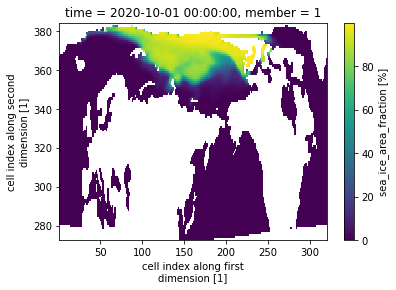

In [52]:
CESM1_SIC['sic'].sel(member=1).sel(time='2020').plot();

**Note the strange layout when we plot, we can see that instead of the north pole at the top we have a pole within Greenland.** <br>
**This grid is more efficient for computation and avoids a pole hole, but it complicates our analysis** <br>
**If we try and plot this using** `cartopy`**, we find that we don't get any data**

/Users/atoc_reu_student/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


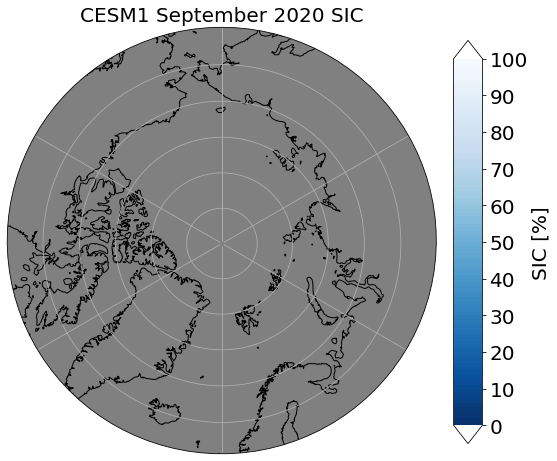

In [53]:
circular_polar_plot(CESM1_SIC['sic'].sel(member=1).sel(time='2020'), 60, 'Blues_r', 'CESM1 September 2020 SIC',
                    cbar_label='SIC [%]', levels_=np.arange(0,101,1), cbar_levels_=np.arange(0,101,10))

## 2.2 Regrid

**In order to plot or compared CESM data we need to regrid** <br>
**Let's first try regridding right out of the box. We'll use the very simple file I've provided to tell** `cdo` **how to do the regirdding:** `Regrid_1x1_deg_30N.txt`

In [54]:
!head Regrid_1x1_deg_30N.txt #this prints the first 10 lines of a file (in this case the whole thing is <10 lines)

gridtype = lonlat
xsize    = 361
ysize    = 61
xfirst   = 0
xinc     = 1
yfirst   = 30
yinc     = 1


**We now follow the format** `cdo remap<TYPE>,<GRID_FILE>, <INFILE> <OUTFILE>`**Find the [documentation is here](https://code.mpimet.mpg.de/projects/cdo/embedded/cdo.pdf).**

In [55]:
!cdo remapbil,Regrid_1x1_deg_30N.txt, CESM_LE_SIC_2000_2020_09_NH.nc CESM_LE_SIC_2000_2020_09_NH_regrid.nc
cdo remapbil,Regrid_1x1_deg_30N.txt, NSIDC_September_SIC_masked_2000_2020.nc NSIDC_September_SIC_2000_2020_regrid.nc

zsh:1: command not found: cdo


**Oh no! We got an error. First we need to make some changes to the file** <br>
`cdo` **requires variables** `lat_vertices` **and** `lon_vertices`**, the easiest way to get this is from the** `areacello` **file and overwrite our data onto the** `areacello` **variable**

In [ ]:
CESM_areacello = xr.open_dataset('areacello_fx_CESM1-CAM5_rcp85_r0i0p0.nc')

In [ ]:
CESM_areacello_NH = CESM_areacello.where(CESM_areacello['lat']>30,drop=True) #just use the coordinates we're interested in

In [ ]:
CESM_areacello_NH['areacello'] = CESM1_SIC['sic'].transpose('time','member','j','i').copy() #CDO needs the time dimension first
CESM_areacello_NH = CESM_areacello_NH.rename({'areacello':'sic'}) #rename the variable to something sensible!

#add attributes
CESM_areacello_NH.attrs = {'Description': 'CESM SIC >30N 2000-2020, Historical and RCP8.5, all 40 members from the large ensemble',
                          'Units': '[million square km]',
                          'Timestamp': str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                          'Souce': 'areacello: /glade/collections/cmip/cmip5/output1/NSF-DOE-NCAR/CESM1-CAM5/rcp85/fx/ocean/fx/r0i0p0/latest/areacello/areacello_fx_CESM1-CAM5_rcp85_r0i0p0.nc, sic: /glade/collections/cdg/data/CLIVAR_LE/cesm_lens/OImon/sic, analysis: REU_2021-06-09_Large_Ensemble.ipynb'}

In [ ]:
CESM_areacello_NH

**Looks good, now save this to a NetCDF file**

In [ ]:
CESM_areacello_NH.to_netcdf('CESM_SIC_2000_2020_09_NH_with_coords.nc')

**Now we're going to do the regridding on this file we've just made.**

In [ ]:
!cdo remapbil,Regrid_1x1_deg_30N.txt, CESM_SIC_2000_2020_09_NH_with_coords.nc CESM_SIC_2000_2020_09_NH_with_coords_regrid.nc

## 2.3 Plot the regridded data
**Yay! It worked this time** <br>
**N.B. this is often a tedious process of trial and error getting everything just right for regridding. Don't exect your first try to work, there are different 'tricks' for other non regular models** <br>
**Now let's open up this regridded datat and plot it**

In [ ]:
CESM_SIC_regrid = xr.open_dataset('CESM_SIC_2000_2020_09_NH_with_coords_regrid.nc')

In [ ]:
CESM_SIC_regrid

In [ ]:
CESM_SIC_regrid['sic'].sel(member=1).sel(time='2020').plot()

**Now we'll plot the regridded CESM data with Cartopy**

In [ ]:
circular_polar_plot(CESM_SIC_regrid['sic'].sel(member=1).sel(time='2020'), 60, 'Blues_r', 'CESM1 September 2020 SIC',
                    cbar_label='SIC [%]', levels_=np.arange(0,101,1), cbar_levels_=np.arange(0,101,10))

**You're done for this morning!** <br>
**Nice job!**

## Dask stuff - for use with a large number of cores to speed up computation

In [ ]:
from dask.distributed import Client
client = Client()
client

In [ ]:
client

**This takes a long time, so we can parallelize this using dask, here is a simple example**

In [ ]:
def SIA_for_member(mem_):
    sum_CanESM2 = weighted_masked_CanESM2.sel(member=mem_).sum('lat').sum('lon')
    return(sum_CanESM2)

In [ ]:
result_list = []
for mem_i in np.arange(1,5,1):
    result_list.append(dask.delayed(SIA_for_member)(mem_i))

In [ ]:
results = dask.compute(*result_list)

In [ ]:
@dask.delayed
def SIA_all_members(weighted_masked_data, mem_len):
    SIA_list = []
    for mem_ in np.arange(1,mem_len+1,1):
        SIA_list.append(weighted_masked_data.sel(member=mem_).sum('lat').sum('lon'))
    
    return(SIA_list)

In [ ]:
SIA_results = SIA_all_members(weighted_masked_CanESM2, 4)

In [ ]:
SIA_results.compute()

In [ ]:
SIA_results

In [ ]:
CanESM2_SIA_month = xr.concat((results), dim='member')

In [ ]:
CanESM2_SIA_month

In [ ]:
new_time = []
for i in (CanESM2_SIA_month['time']):
    new_time.append(np.datetime64(str(i.values)[:4]+'-'+str(i.values)[5:7].zfill(2)+'-'+str(i.values)[8:10]+'T'+str(i.values)[11:13].zfill(2)+':00:00.000'))

In [ ]:
CanESM2_SIA_month['time'] = new_time